In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve,root_scalar,minimize
from scipy.integrate import solve_ivp,quad

In [4]:
plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text rendering
    "font.family": "serif",          # Use a serif font like Computer Modern
    "font.serif": ["Computer Modern"],
    "font.size": 10,                 # General font size (matches LaTeX \normalsize for 11pt)
    "axes.labelsize": 10,            # Font size for axis labels
    "axes.titlesize": 10,            # Font size for plot titles
    "legend.fontsize": 7,            # Font size for legends
    "xtick.labelsize": 7,            # Font size for x-tick labels
    "ytick.labelsize": 7,            # Font size for y-tick labels
    "axes.linewidth": 1,             # Line width for axes
    "lines.linewidth": 1,            # Line width for plot lines
    "patch.linewidth": 1,           # Line width for patches
    "figure.titlesize": 10
})

In [5]:
# scalings
L=1e5;g=9.81; m = 80; P_peloton_hat = 200 # Watts
rho = 1.225; A= 0.36;C_d_avg = 0.7
v_hat_peloton = (2*P_peloton_hat/(C_d_avg*rho*A))**(1/3)
print(v_hat_peloton*3.6) #kph
gravity_term = m*g*v_hat_peloton/P_peloton_hat
print(gravity_term)
acceleration_term = m*v_hat_peloton**3/L/P_peloton_hat

print(acceleration_term)
peloton_time = L/v_hat_peloton
print(peloton_time/3600) # hours
energy_scale = P_peloton_hat*peloton_time
print(energy_scale/4184)#kcal
omega = 0.5
lambda_ = 0.25
N_0 = 5
zeta_0_hat = N_0*4
zeta_0 = zeta_0_hat/L
print(zeta_0)
P_lurking = (0.05 + (1-0.05)*np.exp(-lambda_*zeta_0*L/4))/0.7

print(P_lurking)
C_d_single = 1/0.7
print(C_d_single)
#plt.plot(np.linspace(0,1,100), theta(np.linspace(0,1,100)))
def C_d(zeta):
    if zeta > 0:
        return (0.05 + (1-0.05)*np.exp(-zeta*L/4*lambda_))/0.7 # you are inside the peloton
    elif zeta > 0.001:
        return 1/0.7 # you have fallen behind the peloton and you are by yourself
    else:
        return 1/0.7 # you are ahead of the peloton
C_d_lurking = C_d(zeta_0)
print(C_d_lurking)
prob_crash = 2
P_stable = P_lurking
N = 75
print(prob_crash/N)
epsilon = acceleration_term
C_d(zeta_0)

39.247345458971374
42.77960655027881
0.005183025591188855
2.5479430221475385
438.46055830454776
0.0002
0.46025651002454365
1.4285714285714286
0.46025651002454365
0.02666666666666667


0.46025651002454365

In [6]:
x_attack = 0.5
P_attack = 2 
def RHS(t,state_vec):
    x = state_vec[0]; v = state_vec[1]
    #print(x)
    if x <x_attack:
        power = C_d_lurking
    else: 
        power = P_attack
    
    zeta = t - x

    drag=C_d(zeta)

    acc = 1/epsilon*(power/v - drag*v**2)
    return np.array([v,acc])

sol = solve_ivp(RHS,[0,1],np.array([-zeta_0, 1]),t_eval = np.linspace(0,1,10000), method='LSODA',tol=1e-15 )

/opt/miniconda3/envs/basic/lib/python3.9/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `tol`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


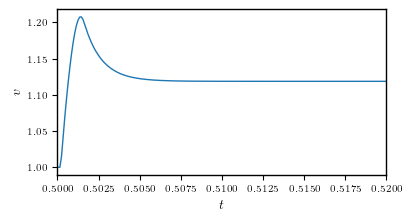

In [7]:
plt.figure(figsize=(4,2.1),constrained_layout=True)
#plt.plot(sol.t, sol.y[0,:])
#plt.plot(sol.t, sol.t)
plt.plot(sol.t, sol.y[1,:])
plt.xlim([0.5,0.52])
plt.ylabel('$v$')
plt.xlabel('$t$')
plt.savefig('acceleration.pdf')


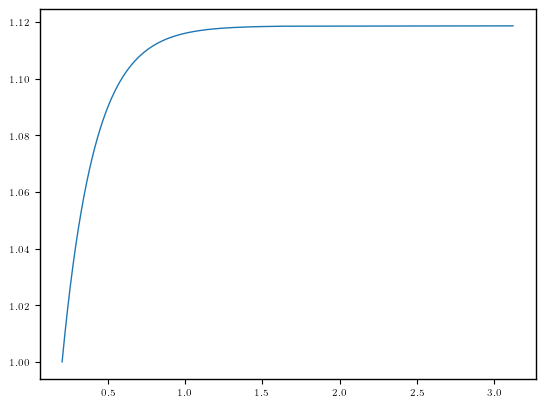

In [10]:
v_max_interior = (P_attack/C_d(0))**(1/3)
v_interior = np.linspace(1,v_max_interior-1E-7, 1000 )
def implicit(v, v_max):
    term1 = np.log((v**2+v*v_max+v_max**2)/(v_max-v)**2)-2*np.sqrt(3)*np.arctan((2*v+v_max)/np.sqrt(3)/v_max)
    return term1
tau = implicit(v_interior, v_max_interior)/v_max_interior/6/C_d(0)
plt.plot(tau, v_interior)
